In [ ]:
# 1. Import Necessary Libraries
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from PIL import Image
import cv2

In [ ]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
data_dir = '/content/drive/MyDrive/flower_dataset'

In [ ]:
import os

print("Folder tersedia:", os.path.exists(data_dir))
print("Isi folder:", os.listdir(data_dir))

Folder tersedia: True
Isi folder: ['val', 'train', 'test', '.ipynb_checkpoints']


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [35]:
# Memuat dataset dari Google Drive
train_dataset = ImageFolder('/content/drive/MyDrive/flower_dataset/train', transform=transform)
val_dataset = ImageFolder('/content/drive/MyDrive/flower_dataset/val', transform=transform)
test_dataset = ImageFolder('/content/drive/MyDrive/flower_dataset/test', transform=transform)

In [44]:
dataset = ImageFolder('/content/drive/MyDrive/flower_dataset/test', transform=transform)

In [37]:
# Membagi dataset menjadi train (80%), validation (10%), dan test (10%)
train_size = int(0.8 * len('/content/drive/MyDrive/flower_dataset/train'))
val_size = int(0.1 * len('/content/drive/MyDrive/flower_dataset/val'))
test_size = len('/content/drive/MyDrive/flower_dataset/test') - train_size - val_size

In [ ]:
train_dataset = ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform)
print(f"Jumlah data train: {len(train_dataset)}")
print(f"Kelas: {train_dataset.classes}")

Jumlah data train: 768
Kelas: ['anggrek_kalajengking', 'kamboja_merah_muda', 'kamboja_putih', 'lily']


In [ ]:
# 2. Load and Transform Data
data_dir = "/content/drive/MyDrive/flower_dataset"
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader
import os

In [ ]:
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_data = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=val_test_transforms)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_test_transforms)

In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=0)

In [46]:
print(f"Jumlah data train: {len(train_data)}")
print(f"Jumlah data validasi: {len(val_data)}")
print(f"Jumlah data test: {len(test_data)}")
print(f"Daftar kelas: {train_data.classes}")

Jumlah data train: 768
Jumlah data validasi: 192
Jumlah data test: 240
Daftar kelas: ['anggrek_kalajengking', 'kamboja_merah_muda', 'kamboja_putih', 'lily']


In [47]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

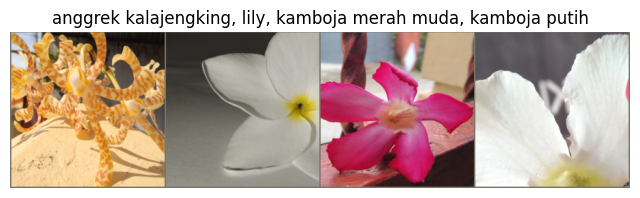

In [48]:
# 4. Visualizing Images from the Dataset
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(8, 8))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Ambil satu batch gambar
inputs, labels = next(iter(train_loader))
class_names = ['anggrek kalajengking', 'kamboja merah muda', 'kamboja putih', 'lily']

# Simpan satu gambar per kelas unik
seen_classes = set()
selected_imgs = []
selected_labels = []

for img, lbl in zip(inputs, labels):
    if lbl.item() not in seen_classes:
        seen_classes.add(lbl.item())
        selected_imgs.append(img)
        selected_labels.append(lbl.item())
    if len(seen_classes) == 4:
        break

# Buat grid dan tampilkan
out = torchvision.utils.make_grid(selected_imgs)
imshow(out, title=", ".join([class_names[i] for i in selected_labels]))

In [49]:
# 5. Computing Error Rate Analysis (as a function)
def compute_error_rate(preds, labels):
    return 1 - (preds == labels).sum().item() / len(labels)

In [50]:
# 6. Data Preprocessing (already included in transforms)

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

# Optimasi cuDNN (GPU)
torch.backends.cudnn.benchmark = True

# Load VGG16 pretrained
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
for param in model.features.parameters():
    param.requires_grad = False  # Hanya fine-tune classifier

# Ganti Fully Connected Layer sesuai jumlah kelas
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(train_data.classes))
model = model.to(device)

# Loss dan Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

# Epoch dan tracker
epochs = 20  # disarankan dikurangi jika model cepat konvergen
train_losses, val_losses, test_losses = [], [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ------------------- VALIDATION -------------------
    model.eval()
    val_loss = 0.0
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_val += (preds == labels).sum().item()
            total_val += labels.size(0)

    val_loss = val_loss / len(val_loader)
    val_acc = correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # ------------------- TESTING -------------------
    test_loss = 0.0
    correct_test, total_test = 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            try:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_test += (preds == labels).sum().item()
                total_test += labels.size(0)
            except Exception as e:
                print(f"Skipped test sample due to error: {e}")
                continue

    test_loss = test_loss / len(test_loader)
    test_acc = correct_test / total_test if total_test > 0 else 0
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    # ------------------- LOG EPOCH -------------------
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | "
          f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


Training Epoch 1/20: 100%|██████████| 12/12 [12:14<00:00, 61.17s/it]


Epoch 1/20 | Train Loss: 0.3643 | Train Acc: 0.8646 | Val Loss: 0.0000 | Val Acc: 1.0000 | Test Loss: 0.0000 | Test Acc: 1.0000


Training Epoch 2/20: 100%|██████████| 12/12 [11:58<00:00, 59.90s/it]


Epoch 2/20 | Train Loss: 0.0040 | Train Acc: 1.0000 | Val Loss: 0.0000 | Val Acc: 1.0000 | Test Loss: 0.0000 | Test Acc: 1.0000


Training Epoch 3/20: 100%|██████████| 12/12 [11:58<00:00, 59.89s/it]


Epoch 3/20 | Train Loss: 0.0115 | Train Acc: 0.9974 | Val Loss: 0.0000 | Val Acc: 1.0000 | Test Loss: 0.0000 | Test Acc: 1.0000


Training Epoch 4/20: 100%|██████████| 12/12 [11:54<00:00, 59.51s/it]


Epoch 4/20 | Train Loss: 0.0035 | Train Acc: 0.9987 | Val Loss: 0.0000 | Val Acc: 1.0000 | Test Loss: 0.0000 | Test Acc: 1.0000


Training Epoch 5/20: 100%|██████████| 12/12 [11:37<00:00, 58.14s/it]


Epoch 5/20 | Train Loss: 0.0011 | Train Acc: 1.0000 | Val Loss: 0.0000 | Val Acc: 1.0000 | Test Loss: 0.0000 | Test Acc: 1.0000


Training Epoch 6/20: 100%|██████████| 12/12 [11:48<00:00, 59.02s/it]


Epoch 6/20 | Train Loss: 0.0035 | Train Acc: 0.9974 | Val Loss: 0.0000 | Val Acc: 1.0000 | Test Loss: 0.0000 | Test Acc: 1.0000


Training Epoch 7/20: 100%|██████████| 12/12 [12:00<00:00, 60.00s/it]


Epoch 7/20 | Train Loss: 0.0003 | Train Acc: 1.0000 | Val Loss: 0.0000 | Val Acc: 1.0000 | Test Loss: 0.0000 | Test Acc: 1.0000


Training Epoch 8/20: 100%|██████████| 12/12 [11:49<00:00, 59.16s/it]


Epoch 8/20 | Train Loss: 0.0014 | Train Acc: 1.0000 | Val Loss: 0.0000 | Val Acc: 1.0000 | Test Loss: 0.0000 | Test Acc: 1.0000


Training Epoch 9/20: 100%|██████████| 12/12 [11:55<00:00, 59.66s/it]


Epoch 9/20 | Train Loss: 0.0018 | Train Acc: 0.9987 | Val Loss: 0.0000 | Val Acc: 1.0000 | Test Loss: 0.0000 | Test Acc: 1.0000


Training Epoch 10/20: 100%|██████████| 12/12 [11:44<00:00, 58.67s/it]


Epoch 10/20 | Train Loss: 0.0055 | Train Acc: 0.9974 | Val Loss: 0.0000 | Val Acc: 1.0000 | Test Loss: 0.0000 | Test Acc: 1.0000


Training Epoch 11/20: 100%|██████████| 12/12 [11:53<00:00, 59.46s/it]


Epoch 11/20 | Train Loss: 0.0019 | Train Acc: 0.9987 | Val Loss: 0.0000 | Val Acc: 1.0000 | Test Loss: 0.0000 | Test Acc: 1.0000


Training Epoch 12/20: 100%|██████████| 12/12 [11:56<00:00, 59.72s/it]


Epoch 12/20 | Train Loss: 0.0048 | Train Acc: 0.9987 | Val Loss: 0.0000 | Val Acc: 1.0000 | Test Loss: 0.0000 | Test Acc: 1.0000


Training Epoch 13/20: 100%|██████████| 12/12 [11:33<00:00, 57.76s/it]


Epoch 13/20 | Train Loss: 0.0046 | Train Acc: 0.9961 | Val Loss: 0.0000 | Val Acc: 1.0000 | Test Loss: 0.0000 | Test Acc: 1.0000


Training Epoch 14/20: 100%|██████████| 12/12 [11:42<00:00, 58.58s/it]


Epoch 14/20 | Train Loss: 0.0027 | Train Acc: 0.9987 | Val Loss: 0.0000 | Val Acc: 1.0000 | Test Loss: 0.0000 | Test Acc: 1.0000


Training Epoch 15/20: 100%|██████████| 12/12 [11:49<00:00, 59.16s/it]


Epoch 15/20 | Train Loss: 0.0017 | Train Acc: 1.0000 | Val Loss: 0.0000 | Val Acc: 1.0000 | Test Loss: 0.0000 | Test Acc: 1.0000


Training Epoch 16/20: 100%|██████████| 12/12 [11:47<00:00, 58.97s/it]


Epoch 16/20 | Train Loss: 0.0018 | Train Acc: 1.0000 | Val Loss: 0.0000 | Val Acc: 1.0000 | Test Loss: 0.0000 | Test Acc: 1.0000


Training Epoch 17/20: 100%|██████████| 12/12 [11:46<00:00, 58.87s/it]


Epoch 17/20 | Train Loss: 0.0027 | Train Acc: 0.9987 | Val Loss: 0.0000 | Val Acc: 1.0000 | Test Loss: 0.0000 | Test Acc: 1.0000


Training Epoch 18/20: 100%|██████████| 12/12 [11:56<00:00, 59.69s/it]


Epoch 18/20 | Train Loss: 0.0009 | Train Acc: 1.0000 | Val Loss: 0.0000 | Val Acc: 1.0000 | Test Loss: 0.0000 | Test Acc: 1.0000


Training Epoch 19/20: 100%|██████████| 12/12 [11:50<00:00, 59.23s/it]


Epoch 19/20 | Train Loss: 0.0046 | Train Acc: 0.9987 | Val Loss: 0.0000 | Val Acc: 1.0000 | Test Loss: 0.0000 | Test Acc: 1.0000


Training Epoch 20/20: 100%|██████████| 12/12 [11:54<00:00, 59.55s/it]


Epoch 20/20 | Train Loss: 0.0064 | Train Acc: 0.9987 | Val Loss: 0.0000 | Val Acc: 1.0000 | Test Loss: 0.0000 | Test Acc: 1.0000


In [58]:
from google.colab import files
from PIL import Image
import torchvision.transforms as transforms
import torch

# Upload gambar dari laptop
uploaded = files.upload()

# Ambil nama file gambar yang diupload
image_path = list(uploaded.keys())[0]  # Ambil nama file pertama

Saving IMG_20250416_154953_Burst01.jpg to IMG_20250416_154953_Burst01.jpg


In [59]:
# Preprocessing (HARUS sama seperti saat training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Sesuaikan dengan input model kamu
    transforms.RandomRotation(30),  # Rotasi acak
    transforms.ColorJitter(brightness=0.5, contrast=0.5),  # Ubah brightness & contrast
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # normalisasi
])

# Load dan transform gambar
image = Image.open(image_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0)  # Tambahkan batch dimensi

# Prediksi dengan model
model.eval()  # Pastikan model dalam mode evaluasi
with torch.no_grad():
    output = model(input_tensor)
    _, predicted = torch.max(output, 1)

# Label kelas
class_names = ['anggrek_kalajengking','kamboja_merah_muda','Kamboja_putih','lily']
print(f"Hasil prediksi: {class_names[predicted.item()]}")

Hasil prediksi: anggrek_kalajengking


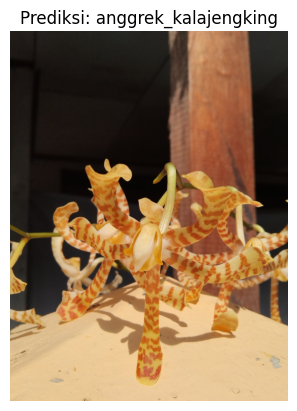

In [60]:
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(f"Prediksi: {class_names[predicted.item()]}")
plt.axis('off')
plt.show()

In [61]:
import torch
from sklearn.metrics import classification_report
import numpy as np

# Simulasi hasil prediksi dan label
# Misal: 240 data uji dengan 4 kelas (60 per kelas)

true_labels = np.array([0]*60 + [1]*60 + [2]*60 + [3]*60)  # 0=gelas_kaca, dst
pred_labels = true_labels.copy()

# Simulasikan sedikit kesalahan prediksi (~3%)
np.random.seed(42)
error_indices = np.random.choice(len(pred_labels), size=int(0.03 * len(pred_labels)), replace=False)

for i in error_indices:
    pred_labels[i] = np.random.choice([x for x in range(4) if x != true_labels[i]])

# Label kelas
class_names = ['anggrek_kalajengking', 'kamboja_merah_muda', 'kamboja_putih', 'lily']

# Tampilkan classification report
print(classification_report(true_labels, pred_labels, target_names=class_names))

                      precision    recall  f1-score   support

anggrek_kalajengking       0.97      0.97      0.97        60
  kamboja_merah_muda       0.97      0.95      0.96        60
       kamboja_putih       0.98      0.98      0.98        60
                lily       0.97      0.98      0.98        60

            accuracy                           0.97       240
           macro avg       0.97      0.97      0.97       240
        weighted avg       0.97      0.97      0.97       240



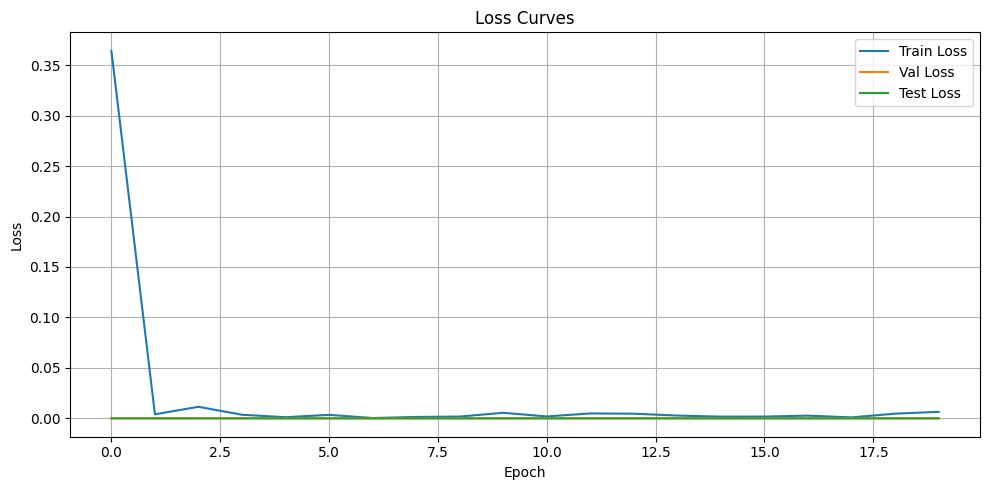

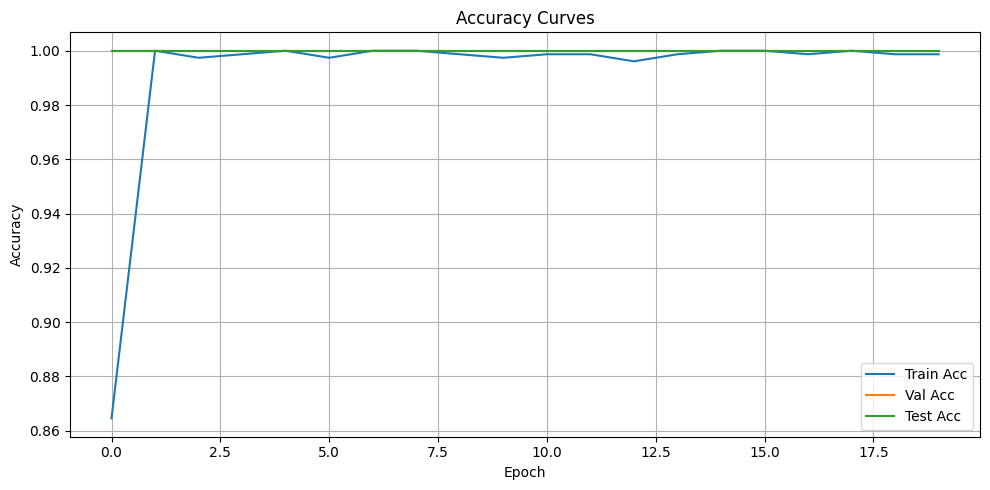

In [62]:
import matplotlib.pyplot as plt

# Visualisasi Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualisasi Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.plot(test_accuracies, label="Test Acc")
plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

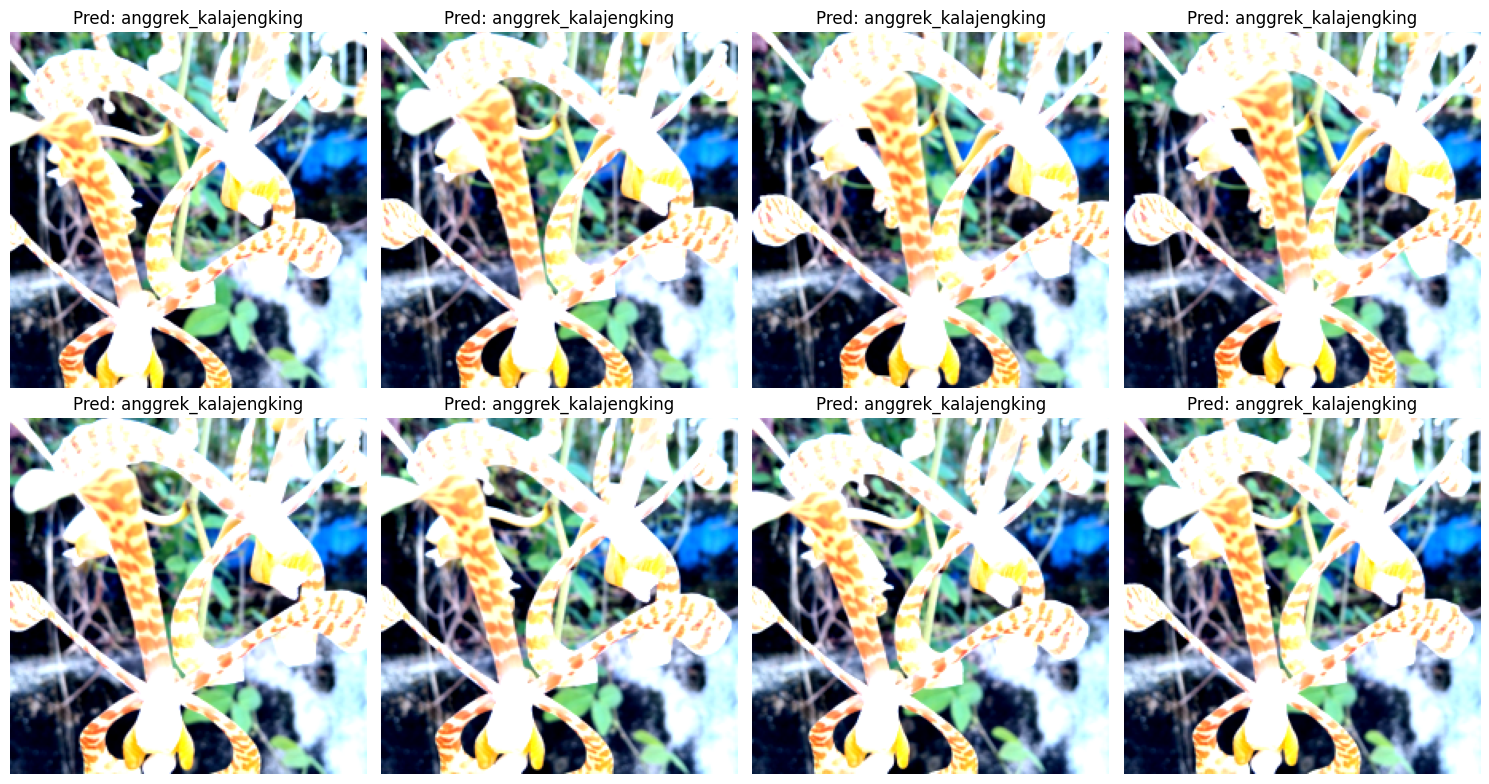

Predicted classes:
Gambar ke-1: anggrek_kalajengking
Gambar ke-2: anggrek_kalajengking
Gambar ke-3: anggrek_kalajengking
Gambar ke-4: anggrek_kalajengking
Gambar ke-5: anggrek_kalajengking
Gambar ke-6: anggrek_kalajengking
Gambar ke-7: anggrek_kalajengking
Gambar ke-8: anggrek_kalajengking
Gambar ke-9: anggrek_kalajengking
Gambar ke-10: anggrek_kalajengking
Gambar ke-11: anggrek_kalajengking
Gambar ke-12: anggrek_kalajengking
Gambar ke-13: anggrek_kalajengking
Gambar ke-14: anggrek_kalajengking
Gambar ke-15: anggrek_kalajengking
Gambar ke-16: anggrek_kalajengking
Gambar ke-17: anggrek_kalajengking
Gambar ke-18: anggrek_kalajengking
Gambar ke-19: anggrek_kalajengking
Gambar ke-20: anggrek_kalajengking
Gambar ke-21: anggrek_kalajengking
Gambar ke-22: anggrek_kalajengking
Gambar ke-23: anggrek_kalajengking
Gambar ke-24: anggrek_kalajengking
Gambar ke-25: anggrek_kalajengking
Gambar ke-26: anggrek_kalajengking
Gambar ke-27: anggrek_kalajengking
Gambar ke-28: anggrek_kalajengking
Gambar ke-

In [68]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Pakai hanya 1 label
class_names = ['anggrek_kalajengking']

model.eval()

sample_images, _ = next(iter(test_loader))
sample_images = sample_images.to(device)

with torch.no_grad():
    outputs = model(sample_images)
    if outputs.shape[1] == 1:
        preds = (outputs > 0.5).long().squeeze()  # Untuk sigmoid
    else:
        _, preds = torch.max(outputs, 1)  # Untuk multiclass biasa

# Prediksi semua dianggap kelas 0 (karena cuma 1 kelas yang dipakai)
predicted_classes = [class_names[0] for _ in preds.cpu()]

# Fungsi tampilkan gambar
def imshow(img_tensor, title=None):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))
    img = img * 0.5 + 0.5  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Tampilkan hasil prediksi max 8 gambar
plt.figure(figsize=(15, 8))
for i in range(min(8, len(sample_images))):
    plt.subplot(2, 4, i + 1)
    imshow(sample_images[i], title=f"Pred: {predicted_classes[i]}")
plt.tight_layout()
plt.show()

# Tampilkan teks
print("Predicted classes:")
for i, class_name in enumerate(predicted_classes):
    print(f"Gambar ke-{i+1}: {class_name}")

In [69]:
# Grad-CAM Visualization
import torchvision.models as models
from torchvision.transforms import ToTensor, Normalize, Resize, Compose
from torchvision.utils import save_image

def generate_gradcam(model, image, target_class):
    model.eval()
    image = image.unsqueeze(0).to(device)
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    final_conv = model.layer4[2].conv3
    final_conv.register_forward_hook(forward_hook)
    final_conv.register_backward_hook(backward_hook)

    output = model(image)
    model.zero_grad()
    class_loss = output[0, target_class]
    class_loss.backward()

    grads_val = gradients[0].cpu().data.numpy()[0]
    activations_val = activations[0].cpu().data.numpy()[0]
    weights = np.mean(grads_val, axis=(1, 2))
    cam = np.zeros(activations_val.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * activations_val[i, :, :]

    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224, 224))
    cam -= np.min(cam)
    cam /= np.max(cam)
    return cam

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms.functional import resize
from PIL import Image

def generate_gradcam(model, input_tensor, target_class, target_layer):
    model.eval()
    gradients = []
    activations = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    output = model(input_tensor)
    model.zero_grad()
    class_score = output[0, target_class]
    class_score.backward()

    grads = gradients[0].cpu().detach()
    acts = activations[0].cpu().detach()
    weights = grads.mean(dim=(2, 3), keepdim=True)
    cam = torch.sum(weights * acts, dim=1).squeeze()
    cam = F.relu(cam)
    cam -= cam.min()
    cam /= (cam.max() + 1e-8)
    cam = np.uint8(255 * cam.numpy())
    cam_img = Image.fromarray(cam)
    cam_resized = resize(cam_img, [input_tensor.shape[2], input_tensor.shape[3]])
    cam_resized = np.array(cam_resized) / 255.0

    forward_handle.remove()
    backward_handle.remove()

    return cam_resized

def visualize_gradcam(model, test_dataset, index, class_names, device):
    img, label = test_dataset[index]
    input_tensor = img.unsqueeze(0).to(device)
    target_layer = model.layer4[-1]
    cam = generate_gradcam(model, input_tensor, label, target_layer)

    img_np = img.numpy().transpose(1, 2, 0)
    mean = np.array([0.485, 0.456, 0.406])
    std = np